#AIM:

Generate random sequences, fold them with RNAfold, learn the mapping between seq features and struct features

Measure how good the mapping is by trying to learn the two version apart

In [229]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
from math import ceil
import numpy as np
from scipy import linalg

def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

In [231]:
from eden.converter.rna.rnafold import rnafold_to_eden
from eden.converter.fasta import sequence_to_eden
from eden.util import mp_pre_process
from eden.util import vectorize
from eden import graph

In [232]:
from eden.util.display import draw_graph
import itertools
def plot(graphs, num=3, opts=None):    
    graphs = itertools.islice(graphs,num)
    for i,graph in enumerate(graphs): 
        draw_graph(graph, **opts)

In [233]:
import random
def generate_rna_seq(length=30, gc_content=0.5):
    n_g=int(gc_content * length / 2)
    n_c=int(gc_content * length / 2)
    n_a=int((1 - gc_content) * length / 2)
    n_u=int((1 - gc_content) * length / 2)
    seq = list('G'*n_g + 'C'*n_c + 'A'*n_a + 'U'*n_u)
    random.shuffle(seq)
    seq = ''.join(seq)
    return seq

def generate_rna_seqs(num=100, length=30, gc_content=0.5):
    seqs = []
    for i in range(num):
        seqs.append(('ID_%d'%i, generate_rna_seq(length=length, gc_content=gc_content)))
    return seqs

In [234]:
def plot_examples(seqs, pre_processor=None):
    graphs = mp_pre_process(seqs,
                            pre_processor=pre_processor,
                            pre_processor_args={},
                            n_jobs=-1)    
    opts={'size':8,
          'node_border':False,
          'node_size':400,
          'font_size':9,
          'vertex_alpha':0.6,
          'title_key':'id',
          'vertex_color':'_labels_',
          'colormap':'Set1',
          'prog':'neato'}
    plot(graphs, num=None, opts=opts)

In [235]:
#RNAplfold
def pre_processor(seqs):
    from eden.converter.rna.rnaplfold import rnaplfold_to_eden
    graphs = rnaplfold_to_eden(seqs,
                               window_size = 30,
                               max_bp_span = 20,
                               avg_bp_prob_cutoff = 0.5,
                               max_num_edges = 1)
    from eden.modifier.graph import structure 
    graphs = structure.basepair_to_nesting(graphs)
    #graphs = structure.del_basepair(graphs)
    return graphs

In [236]:
#RNAfold
def pre_processor(seqs):
    from eden.converter.rna.rnafold import rnafold_to_eden
    graphs = rnafold_to_eden(seqs)
    from eden.modifier.graph import structure 
    graphs = structure.basepair_to_nesting(graphs)
    return graphs

In [237]:
from eden.util import mp_pre_process
from eden.util import vectorize
def transformer(seqs, vectorizer=None, pre_processor=None):
    graphs = mp_pre_process(seqs,
                            pre_processor=pre_processor,
                            pre_processor_args={},
                            n_jobs=-1)
    data_matrix = vectorize(graphs, vectorizer=vectorizer, n_jobs=-1)
    return data_matrix

#Experimental setup

In [238]:
num=2000
length=17
gc_content=0.6
nbits=10

In [239]:
seqs = generate_rna_seqs(num=num, length=length, gc_content=gc_content)

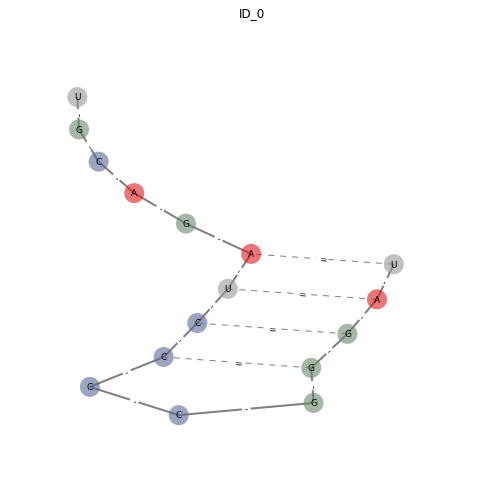

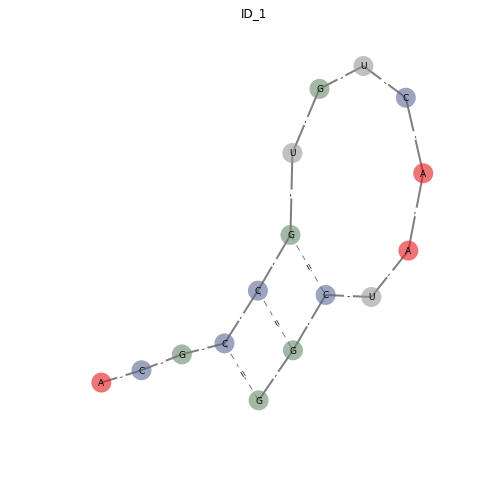

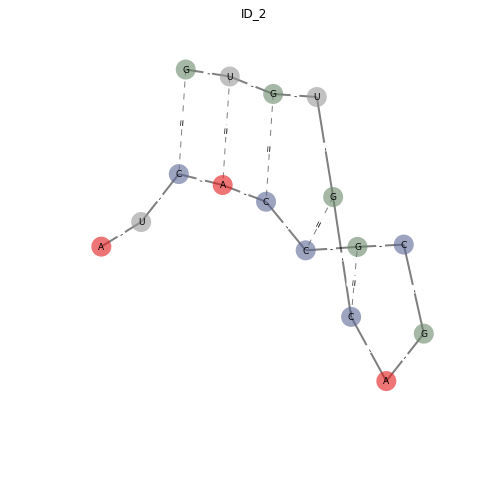

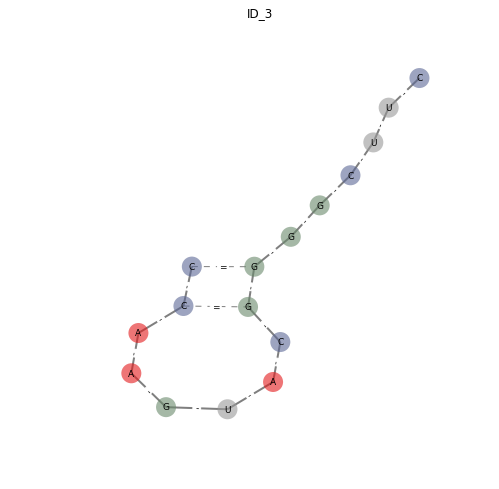

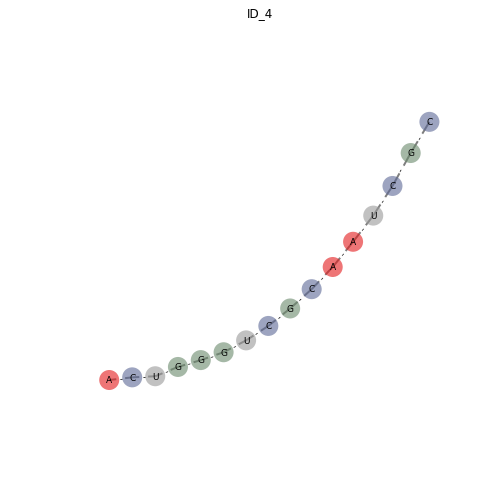

In [240]:
plot_examples(seqs[:5],pre_processor)

In [241]:
%%time
from eden.converter.fasta import sequence_to_eden
from eden import graph
X_seq = transformer(seqs,
                    vectorizer=graph.Vectorizer(r=2,d=17,
                                                normalization=False,
                                                inner_normalization=False,
                                                nbits=nbits),
                    pre_processor=sequence_to_eden)
from eden.util import describe
print describe(X_seq)
print X_seq

Instances: 2000 ; Features: 1025 with an avg of 283 features per instance
  (0, 4)	2.0
  (0, 11)	2.0
  (0, 18)	2.0
  (0, 30)	2.0
  (0, 34)	2.0
  (0, 36)	2.0
  (0, 38)	2.0
  (0, 42)	3.0
  (0, 48)	4.0
  (0, 50)	2.0
  (0, 52)	2.0
  (0, 55)	2.0
  (0, 58)	2.0
  (0, 68)	4.0
  (0, 72)	2.0
  (0, 78)	6.0
  (0, 80)	2.0
  (0, 96)	2.0
  (0, 98)	2.0
  (0, 100)	2.0
  (0, 102)	2.0
  (0, 103)	2.0
  (0, 110)	2.0
  (0, 112)	2.0
  (0, 116)	4.0
  :	:
  (1999, 959)	2.0
  (1999, 962)	4.0
  (1999, 963)	2.0
  (1999, 964)	2.0
  (1999, 967)	2.0
  (1999, 971)	2.0
  (1999, 972)	6.0
  (1999, 974)	1.0
  (1999, 976)	2.0
  (1999, 980)	2.0
  (1999, 982)	2.0
  (1999, 984)	2.0
  (1999, 986)	2.0
  (1999, 987)	2.0
  (1999, 990)	2.0
  (1999, 992)	4.0
  (1999, 993)	2.0
  (1999, 1000)	2.0
  (1999, 1002)	2.0
  (1999, 1008)	2.0
  (1999, 1011)	2.0
  (1999, 1012)	4.0
  (1999, 1020)	2.0
  (1999, 1022)	2.0
  (1999, 1024)	2.0
CPU times: user 3.45 s, sys: 379 ms, total: 3.83 s
Wall time: 7.61 s


In [242]:
%%time
from eden.converter.fasta import sequence_to_eden
from eden import graph
X_struct = transformer(seqs,
                       vectorizer=graph.Vectorizer(r=3,d=0,
                                                   normalization=False,
                                                   inner_normalization=False,
                                                   nbits=nbits),
                       pre_processor=pre_processor)
from eden.util import describe
print describe(X_struct)
print X_struct

Instances: 2000 ; Features: 1025 with an avg of 50 features per instance
  (0, 42)	3.0
  (0, 52)	1.0
  (0, 78)	1.0
  (0, 87)	1.0
  (0, 127)	1.0
  (0, 144)	1.0
  (0, 198)	1.0
  (0, 216)	3.0
  (0, 234)	5.0
  (0, 255)	1.0
  (0, 258)	1.0
  (0, 278)	2.0
  (0, 301)	2.0
  (0, 304)	1.0
  (0, 308)	1.0
  (0, 340)	1.0
  (0, 352)	1.0
  (0, 406)	1.0
  (0, 454)	1.0
  (0, 462)	1.0
  (0, 464)	1.0
  (0, 469)	2.0
  (0, 470)	1.0
  (0, 484)	1.0
  (0, 500)	1.0
  :	:
  (1999, 538)	1.0
  (1999, 543)	1.0
  (1999, 568)	2.0
  (1999, 610)	5.0
  (1999, 662)	1.0
  (1999, 726)	2.0
  (1999, 750)	2.0
  (1999, 767)	1.0
  (1999, 775)	1.0
  (1999, 790)	2.0
  (1999, 816)	1.0
  (1999, 822)	1.0
  (1999, 846)	1.0
  (1999, 864)	1.0
  (1999, 874)	1.0
  (1999, 883)	1.0
  (1999, 954)	1.0
  (1999, 966)	1.0
  (1999, 972)	1.0
  (1999, 974)	1.0
  (1999, 982)	2.0
  (1999, 1002)	2.0
  (1999, 1012)	1.0
  (1999, 1014)	1.0
  (1999, 1023)	1.0
CPU times: user 3.27 s, sys: 556 ms, total: 3.83 s
Wall time: 10.9 s


In [243]:
from sklearn.preprocessing import StandardScaler
seq_scale = StandardScaler(with_mean=True)
X_seq_std = seq_scale.fit_transform(X_seq.todense())
print X_seq_std

[[ 0.         -0.36576885 -0.4756161  ..., -0.59406841 -0.3666469
  -0.4971412 ]
 [ 0.         -0.36576885  1.89063315 ..., -0.59406841 -0.3666469
  -0.4971412 ]
 [ 0.         -0.36576885  1.89063315 ..., -0.59406841 -0.3666469
  -0.4971412 ]
 ..., 
 [ 0.         -0.36576885 -0.4756161  ...,  1.60211794 -0.3666469
  -0.4971412 ]
 [ 0.         -0.36576885  1.89063315 ..., -0.59406841 -0.3666469
  -0.4971412 ]
 [ 0.         -0.36576885 -0.4756161  ...,  1.60211794 -0.3666469
   1.93982547]]


In [244]:
from sklearn.preprocessing import StandardScaler
struct_scale = StandardScaler(with_mean=True)
X_struct_std = seq_scale.fit_transform(X_struct.todense())
print X_struct_std

[[ 0.         -0.15171652 -0.07088812 ..., -0.08088589 -0.26916612
  -0.03875891]
 [ 0.         -0.15171652 -0.07088812 ..., -0.08088589 -0.26916612
  -0.03875891]
 [ 0.         -0.15171652 -0.07088812 ..., -0.08088589 -0.26916612
  -0.03875891]
 ..., 
 [ 0.         -0.15171652 -0.07088812 ..., -0.08088589  3.60372767
  -0.03875891]
 [ 0.         -0.15171652 -0.07088812 ..., -0.08088589 -0.26916612
  -0.03875891]
 [ 0.         -0.15171652 -0.07088812 ..., -0.08088589  3.60372767
  -0.03875891]]


In [245]:
X_seq_std = X_seq.todense()
X_struct_std = X_struct.todense()

In [246]:
n_features_in = X_seq.shape[1]
n_features_out = X_struct.shape[1]
n_features_hidden = max(n_features_in, n_features_out) * 2
print 'n_neurons: #in [%d] -- #hidden [%d] -- #out [%d]' % (n_features_in, n_features_hidden, n_features_out)

n_neurons: #in [1025] -- #hidden [2050] -- #out [1025]


In [247]:
from sknn.mlp import Regressor, Layer

net = Regressor(layers=[
        Layer("Rectifier", units=n_features_hidden),
        Layer("Rectifier", units=n_features_hidden),
        Layer("Rectifier", units=n_features_hidden),
        Layer("Linear", units=n_features_out)],
                learning_rate=0.0001,
                n_iter=40,
                batch_size=10,
                regularize='L1',
                valid_size=0.1)

In [248]:
%%time
net.fit(X_seq_std, X_struct_std)

CPU times: user 36min 37s, sys: 3min 18s, total: 39min 55s
Wall time: 23min 21s


Regressor(batch_size=10, debug=False, dropout_rate=None, f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: name=u'hidden0', units=2050>,
     hidden1=<sknn.nn.Layer `Rectifier`: name=u'hidden1', units=2050>,
     hidden2=<sknn.nn.Layer `Rectifier`: name=u'hidden2', units=2050>,
     layers=[<sknn.nn.Layer `Rectifier`: name=u'hidden0', units=2050>, <sknn.nn.Layer `Rectifier`: name=u'hidden1', units=2050>, <sknn.nn.Layer `Rectifier`: name=u'hidden2', units=2050>, <sknn.nn.Layer `Linear`: name=u'output', units=1025>],
     learning_momentum=0.9, learning_rate=0.0001, learning_rule=u'sgd',
     loss_type=u'mse', mutator=None, n_iter=40, n_stable=50,
     output=<sknn.nn.Layer `Linear`: name=u'output', units=1025>,
     random_state=None, regularize='L1',
     valid_set=(matrix([[ 0.,  2., ...,  2.,  0.],
        [ 0.,  0., ...,  0.,  2.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  2.]]), matrix([[ 0.,  0., ...,  0.,  0.],
        [ 0.,  1., ...,  0

In [249]:
%%time
# Transform seq features to struct features
X_struct_std_pred = net.predict(X_seq_std)

CPU times: user 4.37 s, sys: 38.2 ms, total: 4.41 s
Wall time: 737 ms


In [250]:
import pylab as plt
import numpy as np

original_data = np.array(np.ravel(X_struct_std))
predicted_data = np.array(np.ravel(X_struct_std_pred))

combined_data = np.vstack([original_data,predicted_data])
gamma = np.corrcoef(combined_data)
print 'corr_coeff: %.3f' % gamma[0,1]
print 'n datapoints: %d' % predicted_data.shape[0]

corr_coeff: 0.817
n datapoints: 2050000


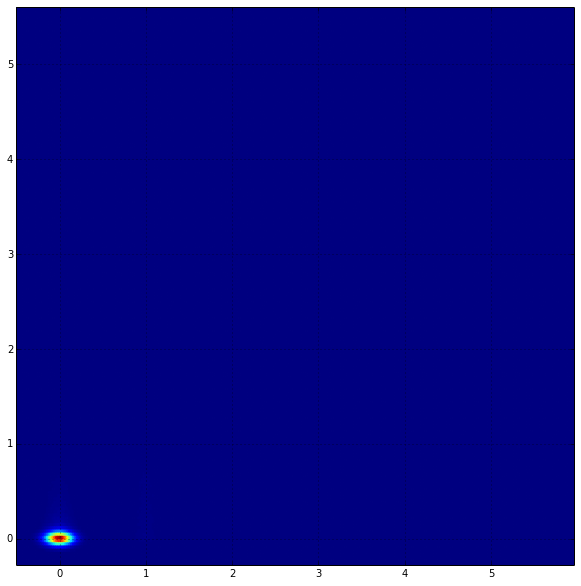

CPU times: user 13.9 s, sys: 253 ms, total: 14.1 s
Wall time: 14.1 s


In [262]:
%%time
plt.figure(figsize=(10,10)) 
noise = 0.1 * np.random.randn(*original_data.shape)
noisy_original_data = noise + original_data
plt.hexbin(noisy_original_data,predicted_data, gridsize=300)
#plt.scatter(noisy_original_data,predicted_data)
plt.grid()
plt.show()

In [ ]:
%%time
smoothed_predicted_data = lowess(original_data,predicted_data)

plt.figure(figsize=(10,10)) 
plt.scatter(original_data,predicted_data)
plt.scatter(original_data,smoothed_predicted_data, c='r')
plt.grid()
plt.show()

---